In [13]:
import seaborn as sns
import pandas as pd
import geopandas 
import pysal
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights


### US State per Capita Income 1969-2017

In [19]:
ls

BBSpatial_data.ipynb                  Spatial_Weights.ipynb
Global_Spatial_Autocorrelation.ipynb  Spatial_inequality_dynamics.ipynb
Local_Spatial_Autocorrelation.ipynb   Untitled.ipynb
Point_Patern_Analysis.ipynb           cache/
README.md                             geo_data/
Spatial_Data_Analysis.ipynb           uscountypcincome.gpkg


In [22]:
pci_df = geopandas.read_file("uscountypcincome.gpkg", layer='pcincome')


In [25]:
pci_df.columns #wide format

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

In [26]:
pci_df.shape

(3076, 77)

In [27]:
pci_df.query('NAME == "Jackson" & STATEFP == "28"').loc[
    :, "1969":"1979"
]

,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979
1417,2957,3121,3327,3939,4203,4547,5461,5927,6315,6619,6967


## Global Inequality

- “Global” means that the measure is concerned with the overall nature of inequality within the income distribution.

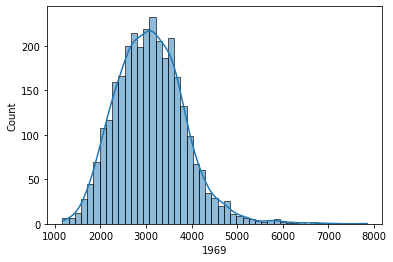

In [28]:
sns.histplot(x=pci_df["1969"], kde=True); #per capita incomes for each county

- the regional distributions are based on averages obtained from the individual distributions, and so the extremely high-income individuals are averaged with the rest of their county. 

In [29]:
pci_df = pci_df.to_crs(
    # Albers Equal Area North America
    epsg=5070
)

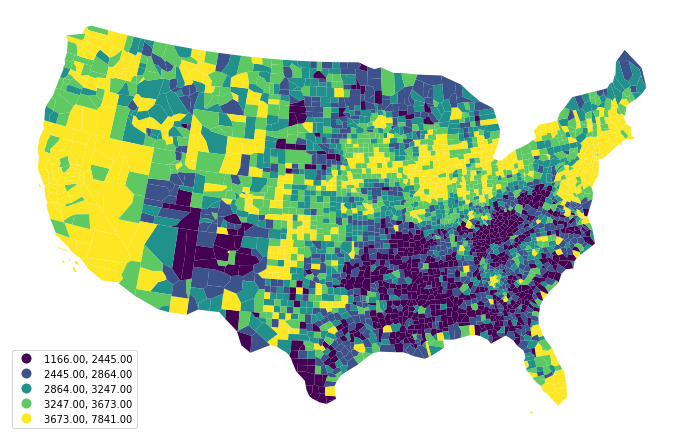

In [30]:
ax = pci_df.plot(
    column="1969",
    scheme="Quantiles",
    legend=True,
    edgecolor="none",
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.show()

## 20:20 Ratio

- One commonly used measure of inequality in a distribution is the so called 20:20 ratio, which is defined as the ratio of the incomes at the 80th percentile over that at the 20th percentile:

In [32]:
top20, bottom20 = pci_df["1969"].quantile([0.8, 0.2])

In [33]:
top20 / bottom20 #generate the ration

1.5022494887525562

- In 1969 the richest 20% of the counties had an income that was 1.5 times the poorest 20% of the counties. 
- Robust to outliers at the top and the bottom of the distribution

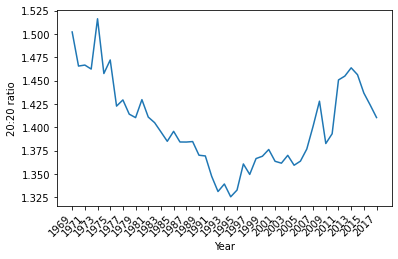

In [35]:
def ineq_20_20(values):
    top20, bottom20 = values.quantile([0.8, 0.2])
    return top20 / bottom20


# Generate range of strings from 1969 to 2018
years = np.arange(1969, 2018).astype(str)
# Compute 20:20 ratio for every year
ratio_2020 = pci_df[years].apply(ineq_20_20, axis=0)
# Plot evolution of 20:20 ratio
ax = plt.plot(years, ratio_2020)

# Grab figure generated in the plot
figure = plt.gcf()
# Replace tick labels with every other year
plt.xticks(years[::2])
# Set vertical label
plt.ylabel("20:20 ratio")
# Set horizontal label
plt.xlabel("Year")
# Rotate year labels
figure.autofmt_xdate(rotation=45)

plt.show()

- Post 1994, however, the 20:20 ratio indicates there is increasing inequality up until 2013, where there is a turn towards lower income inequality between the counties.

In [36]:
# Gini and Theil's indices

In [37]:
from pysal.explore import inequality

## Gini Index

- The Gini index is a longstanding measure of inequality based on the notion of cumulative wealth distribution . The Gini is closely linked to another popular device called the Lorenz curve . To construct a Lorenz curve, the cumulative share of wealth is plotted against the share of the population that owns that wealth

- In contrast, a “perfectly equal” society would look like a straight line connecting (0,0)and (1,1). This is called the line of perfect equality, and represents the case where p% of the population owns exactly p% of the wealth. For example, this might mean that 50% of the population earns exactly 50% of the income, or 90% of the population owns 90% of the wealth.

- In an extremely unequal society where few people own nearly all the wealth, the Lorenz curve increases very slowly at first, then skyrockets once the wealthiest people are included.

- Gini index is defined as the ratio of the area between the line of perfect equality and the Lorenz curve for a given income or wealth distribution, standardized by the area under the line of perfect equality (which is always 12). 

In [38]:
#Construct the Lorenz curve for 1969 by first computing the share of our 
#population of counties that is below each observation. 

In [40]:
n = len(pci_df)
share_of_population = np.arange(1, n + 1) / n

In [41]:
n

3076

In [44]:
share_of_population.shape

(3076,)

In [45]:
# cumulative evolution of income
# find proportion of total income owned by each share of the population

In [46]:
# sort counties incomes
incomes = pci_df["1969"].sort_values()

In [ ]:
#find overall percentage of the total income that of each county represents

In [47]:
shares = incomes / incomes.sum()

- construct the cumulative sum of these shares, which reflects the sum of all of the shares of income up to the current one:

In [49]:
cumulative_share = shares.cumsum()
cumulative_share

2647    0.000122
78      0.000253
2981    0.000384
1047    0.000515
973     0.000651
          ...   
1710    0.997011
2661    0.997712
2901    0.998429
2633    0.999176
1802    1.000000
Name: 1969, Length: 3076, dtype: float64

In [ ]:
#plot Lorez curve and line of perfect equality

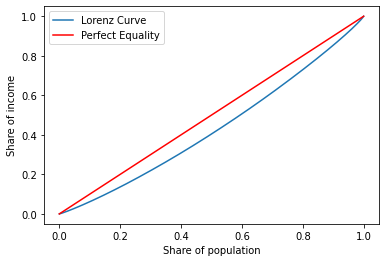

In [50]:
# Generate figure with one axis
f, ax = plt.subplots()
# Plot Lorenz Curve
ax.plot(share_of_population, cumulative_share, label="Lorenz Curve")
# Plot line of perfect equality
ax.plot((0, 1), (0, 1), color="r", label="Perfect Equality")
# Label horizontal axis
ax.set_xlabel("Share of population")
# Label vertical axis
ax.set_ylabel("Share of income")
# Add legend
ax.legend()

plt.show()

The blue line is the Lorenz curve for county incomes in 1969. The Gini index is the area between it and the 45-degree line of equality shown in red, all standardized by the area underneath the line of equality.

In [51]:
def lorenz(y):
    y = np.asarray(y)
    incomes = np.sort(y)
    income_shares = (incomes / incomes.sum()).cumsum()
    N = y.shape[0]
    pop_shares = np.arange(1, N + 1) / N
    return pop_shares, income_shares

In [52]:
lorenz(pci_df["1969"])

(array([3.25097529e-04, 6.50195059e-04, 9.75292588e-04, ...,
        9.99349805e-01, 9.99674902e-01, 1.00000000e+00]),
 array([1.22486441e-04, 2.52956561e-04, 3.83636778e-04, ...,
        9.98429316e-01, 9.99176315e-01, 1.00000000e+00]))

In [56]:
lorenz_curves = pci_df[years].apply(lorenz, axis=0)
lorenz_curves

,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...",...,"[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553...","[0.00032509752925877764, 0.0006501950585175553..."
1,"[0.00012248644113964493, 0.0002529565611185806...","[0.00013470713147942766, 0.0002749742242147042...","[0.00013565871276465116, 0.0002735829350945102...","[0.000138851418132282, 0.0002856978062862818, ...","[0.00013772329900895125, 0.0002789403397482158...","[0.00013670247958589532, 0.0002822671421734887...","[0.00013545577965044458, 0.0002969630997663923...","[0.00013285409901160207, 0.0002894117453533050...","[0.0001243028615204895, 0.00025562579972132935...","[0.00012461982501385657, 0.0002617767612857009...",...,"[0.00014337413757142982, 0.0002952111969255050...","[0.0001456829143536576, 0.00030689603606708245...","[0.00014395847223286045, 0.000300079481701999,...","[0.00014303960415837748, 0.0002879780824635754...","[0.00014868735880996665, 0.0003029537221659007...","[0.00014777376351708422, 0.0002978443977606638...","[0.00011563121829018938, 0.0002592947418121832...","[0.00010564770915523224, 0.0002539806359455832...","[0.00014203484354254357, 0.0002909593179418555...","[9.276898012960255e-05, 0.0002421381514532987,..."


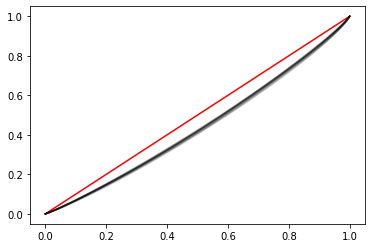

In [55]:

f, ax = plt.subplots()
# Plot line of perfect equality
ax.plot((0, 1), (0, 1), color="r")
# Loop over every year in the series
for year in lorenz_curves.columns:
    # Extract the two arrays or each dimension
    year_pop_shares, year_inc_shares = lorenz_curves[year].values
    # Plot Lorenz curve for a given year
    ax.plot(year_pop_shares, year_inc_shares, color="k", alpha=0.05)

In [59]:
g69 = inequality.gini.Gini(pci_df["1969"].values)

In [60]:
g69.g

0.13556175504269904

In [61]:
#Compute gini index for every year

In [62]:
def gini_by_col(column):
    return inequality.gini.Gini(column.values).g

In [63]:
inequalities = (
    pci_df[years].apply(gini_by_col, axis=0).to_frame("gini")
)

In [64]:
inequalities.head()

,gini
1969,0.135562
1970,0.130076
1971,0.128540
1972,0.129126
1973,0.142166


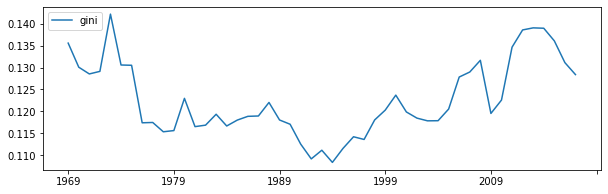

In [65]:
inequalities.plot(figsize=(10, 3));

## Theil’s index

Theil's $T$ given as:

$$T = \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right)$$

where $y_i$ is per capita income in area $i$ among $m$ areas. Conceptually, this metric is related to the entropy of the income distribution, measuring how evenly-distributed incomes are across the population.

The Theil index is also available in Pysal's `inequality`, so we can take a similar approach as above to calculate it for every year:

In [67]:
def theil(column):
    return inequality.theil.Theil(column.values).T


inequalities["theil"] = pci_df[years].apply(theil, axis=0)

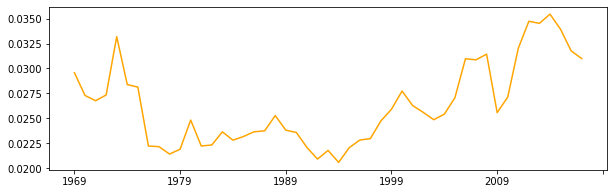

In [68]:
inequalities["theil"].plot(color="orange", figsize=(10, 3));

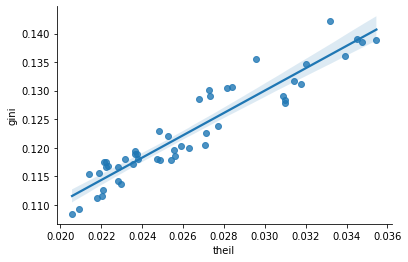

In [71]:
sns.regplot(x="theil", y="gini", data=inequalities);
sns.despine()

## Personal versus Regional Income

There is a subtle but important distinction between the study of personal and
regional income inequality. To see this, we first need to express the
relationships between the two types of inequality. Consider a country composed
of $N$ individuals who are distributed over $m$ regions. Let $Y_l$ denote the
income of individual $l$. Total personal income in region $i$ is given as $Y_i =
\sum_{l \in i} Y_l$, and per capita income in region $i$ is $y_i = \frac{Y_i}{N_i}$,
where $N_i$ is the number of individuals in region $i$.

At the national level,  the coefficient of variation in incomes could be used as an index of interpersonal income inequality. This would be:

$$CV_{nat} = \sqrt{\frac{\sum_{l=1}^N (Y_l - \bar{y})^2}{N}}$$

where $\bar{y}$ is the national average for per capita income. The key component here is the sum
of squares term, and unpacking this sheds light on personal versus regional
inequality question:

$$TSS = \sum_{l=1}^N (Y_l - \bar{y})^2$$

An individual deviation, $\delta_l = Y_l - \bar{y}$, is the contribution to inequality associated with individual $l$. We can break this into two components:

$$\delta_l = (Y_l - y_i) +  (y_i - \bar{y})$$

The first term is the difference between the individual's income and per capita income in the individual's region of residence, while the second term is the difference between the region's per capita income and average national per capita income.

In regional studies, the intra-regional personal income distribution is typically
not available. As a result, the assumption is often made that intra-regional
personal inequality is zero. In other words, all individuals in the same region
have identical incomes. With this assumption in hand, the first term vanishes:
$Y_l -y_i = 0$, leading to:[^reg] 

[^reg]: It should also be noted that even at the national scale, the analysis of interpersonal income inequality also relies on aggregate data grouping individuals into income cohorts. See, for example, {cite}`Piketty_2003`.

$$
\begin{aligned}
TSS &= \sum_{l=1}^N (Y_l - \bar{y})^2 \\
    &= \sum_{l=1}^N \delta_l^2 \\
    &= \sum_{l=1}^N ((Y_l - y_i) +  (y_i - \bar{y}))^2 \\
    &= \sum_{l=1}^N (0 +  (y_i - \bar{y}))^2 \\
    &= \sum_{i=1}^m\sum_{l \in i}  (y_i - \bar{y})^2 \\
    &= \sum_{i=1}^m  [N_i(y_i - \bar{y})]^2
\end{aligned}
$$

This means that each individual in a region has an equal contribution to the
overall level of national interpersonal inequality, given by $(y_i - \bar{y})$,
while the region in question contributes $N_i(y_i - \bar{y})$. While it may seem
that the assumption of zero intra-regional interpersonal income inequality is
overly restrictive, it serves to isolate the nature of inter-regional income
inequality. That is, inequality between places, rather than inequality between
people within those places. In essence, this strategy shifts the question up one
level in the spatial hierarchy by aggregating micro-level individual data to
areal units.


## Spatial Inequality

-------------------------------------

### Spatial Autocorrelation

In [74]:
wq = weights.Queen.from_dataframe(pci_df)
wq

Here, we will also keep the pseudo p-value for the Moran statistic which, as we saw in Chapter 6, helps us identify whether the index is statistically significant under the null hypothesis that incomes are randomly distributed geographically.

In [75]:
def moran_by_col(y, w=wq):
    mo = esda.Moran(y, w=w)
    mo_s = pd.Series(
        {"I": mo.I, "I-P value": mo.p_sim},
    )
    return mo_s

In [76]:
moran_stats = pci_df[years].apply(moran_by_col, axis=0).T

moran_stats.head()

,I,I-P value
1969,0.649090,0.001
1970,0.647438,0.001
1971,0.626546,0.001
1972,0.606760,0.001
1973,0.640226,0.001


In [77]:
inequalities = inequalities.join(moran_stats)

In [78]:
inequalities

,gini,theil,I,I-P value
1969,0.135562,0.029572,0.649090,0.001
1970,0.130076,0.027290,0.647438,0.001
1971,0.128540,0.026764,0.626546,0.001
1972,0.129126,0.027336,0.606760,0.001
1973,0.142166,0.033196,0.640226,0.001
1974,0.130579,0.028383,0.627158,0.001
1975,0.130513,0.028132,0.613811,0.001
1976,0.117412,0.022211,0.606031,0.001
1977,0.117482,0.022149,0.614522,0.001
1978,0.115366,0.021406,0.610277,0.001


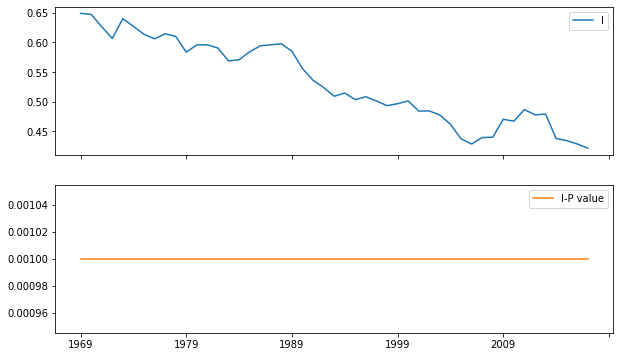

In [79]:
inequalities[["I", "I-P value"]].plot(subplots=True, figsize=(10, 6))
plt.show();

- while Gini and Theil indices from previous figures follow a similar path, Moran’s I displays a distinct trajectory. There is a long-term decline in the value of Moran’s I. This suggests a gradual decline in the geographic structure of inequality with two implications: (a) per capita incomes are now less similar between nearby counties and (b), this has been consistently declining, regardless of whether inequality is high or low.


- Second, despite this decline, there is never a year in which the spatial autocorrelation is not statistically significant. In other words, there is a strong geographic structure in the distribution of regional incomes that needs to be accounted for when focusing on inequality questions.

## Regional Decomposition of Inequality

-  Often useful to decompose inequality indices into constituent groups. 
- This allows us to understand how much of inequality is driven by aggregate group differences and how much is driven by observation-level inequality

In [80]:
region_names = {
    1: "New England",
    2: "Mideast",
    3: "Great Lakes",
    4: "Plains",
    5: "Southeast",
    6: "Southwest",
    7: "Rocky Mountain",
    8: "Far West",
}

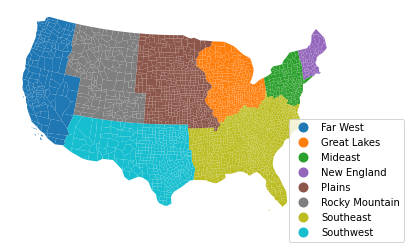

In [81]:
ax = pci_df.assign(Region_Name=pci_df.Region.map(region_names)).plot(
    "Region_Name",
    linewidth=0,
    legend=True,
    categorical=True,
    legend_kwds=dict(bbox_to_anchor=(1.2, 0.5)),
)
ax.set_axis_off();

In [82]:
# apply a split-apply-combine pattern that groups counties by region, calculates its mean, 
#and combines it into a table:

In [83]:
rmeans = (
    pci_df.assign(
        # Create column with region name for each county
        Region_Name=pci_df.Region.map(region_names)
    )
    .groupby(
        # Group counties by region name
        by="Region_Name"
        # Calculate mean by region and save only year columns
    )
    .mean()[years]
)



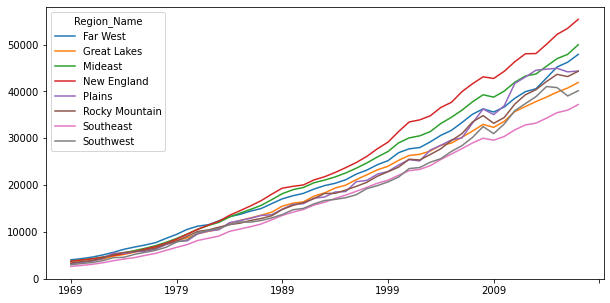

In [84]:
rmeans.T.plot.line(figsize=(10, 5));

Theil's $T$, which we encountered previously, can be decomposed using regions into so called *between* and *within* regional inequality components.
To proceed in this direction, we first re-conceptualize our observations of per capita incomes for $m$ regional economies as $y = \left( y_1, y_2, \ldots, y_m \right)$. These are grouped into $\omega$ mutually exclusive regions. Formally, this means that when $m_g$ represents the number of areas assigned to region $g$, the total number of areas must be equal to the count of all the areas in each region: $\sum_{g=1}^{\omega} m_g=m$.[^mut-ex] With this notation, Theil's index from above can be rewritten to emphasize its between and within components:

[^mut-ex]: This would be violated, for example, if one area were in two regions. This area would get "double counted" in this total. 

$$
\begin{aligned}
T &= \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right) \\
  &= \left[ \sum_{g=1}^{\omega} s_{g} \ln \left(\frac{m}{m_g} s_g \right)  \right] + \left[ \sum_{g=1}^{\omega} s_g \sum_{i \in g} s_{i,g} \ln \left(m_g s_{i,g}\right) \right] \\
  &= B + W \\
\end{aligned}
$$

where $s_g = \frac{\sum_{i \in g} y_i}{\sum_i y_i}$, and   $s_{i,g} = y_i / \sum_{i \in g} y_i$. 

The first term is the between regions inequality component, and the second is
the within regions inequality component. The within regions term is a weighted
average of inequality between economies belonging to the same region. Similar
to what is done above for the case of interpersonal inequality, the estimate of
the between region (group) component of the decomposition is based on setting
the incomes of all economies (individuals) belonging to a region (group) equal
to that of the regional (group) average of these per capita incomes. Now,
however, intra-regional inequality between economies within the same region is
explicitly considered in the second component.[^weight]

[^weight]: The regional decomposition does not involve weighting the regions by their respective population. See  {cite}`Gluschenko_2018` for further details. 




In [85]:
theil_dr = inequality.theil.TheilD(
    pci_df[years].values, pci_df.Region
)

In [86]:
theil_dr.bg

array([0.00914353, 0.00822696, 0.00782675, 0.00768201, 0.01022634,
       0.0081274 , 0.00783943, 0.00572543, 0.00560271, 0.0054971 ,
       0.00511791, 0.00566001, 0.00486877, 0.00466134, 0.00474425,
       0.00424528, 0.00428434, 0.00453503, 0.00465829, 0.00456699,
       0.00467363, 0.00412391, 0.00366334, 0.00342112, 0.00327131,
       0.00312475, 0.00326071, 0.00359733, 0.00327591, 0.00363014,
       0.00382409, 0.00436261, 0.00399156, 0.00402506, 0.00397   ,
       0.00394649, 0.00353368, 0.00362698, 0.00400508, 0.00449814,
       0.0043533 , 0.00470988, 0.0063954 , 0.00642426, 0.00694236,
       0.00644971, 0.00591871, 0.00554072, 0.00528702])

In [87]:
inequalities["theil_between"] = theil_dr.bg
inequalities["theil_within"] = theil_dr.wg

In [89]:
#ompute the share of the Theil index due to the between-region inequality

inequalities["theil_between_share"] = (
    inequalities["theil_between"] / inequalities["theil"]
)

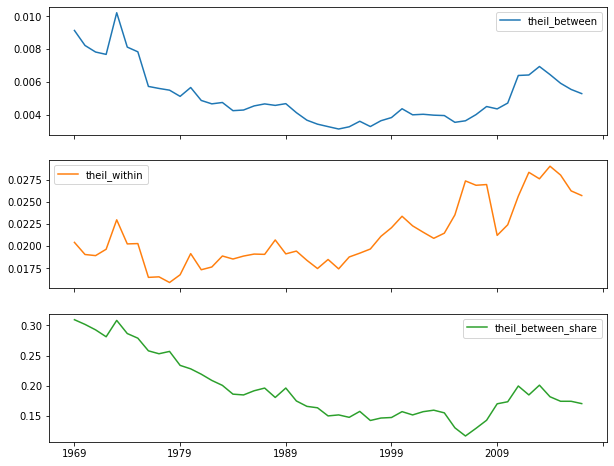

In [90]:
inequalities[
    ["theil_between", "theil_within", "theil_between_share"]
].plot(subplots=True, figsize=(10, 8));

The between-region share of inequality is at its lowest in the mid-2000s, not in the mid-1990s. This suggests that regional differences were very important in the 1970s and 1980s, but this importance has been waning

## Spatializing Classic Measures

 The spatial Gini is designed to consider the role of spatial adjacency in a decomposition of the traditional Gini. The original index can be formulated focusing on the set of pairwise absolute differences in incomes:

$$G = \frac{\sum_i \sum_j \left | y_i - y_j \right|}{2 n^2 \bar{y}} $$

where $n$ is the number of observations, and $\bar{y}$ is the mean regional income. Focusing on the set of pairwise absolute differences in income, we can de-compose this into the set of differences between "nearby" observations and the set of differences among "distant" observations. This is the main conceptual point of the "Spatial Gini" coefficient. This decomposition works similarly to the regional decomposition of the Theil index:

$$
\sum_i \sum_j \left |y_i - y_j \right | =\sum_i \sum_j \underset{\text{near differences}}{\left( w_{ij} \left |y_i - y_j \right | \right )} + \underset{\text{far differences}}{\left( (1-w_{ij})  \left |y_i - y_j \right | \right )}
$$

In this decomposition, $w_{ij}$ is a binary variable that is $1$ when $i$ and $j$ are neighbors, and is zero otherwise. Recalling the spatial weights matrices from (spatial_weights), this can be used directly from a spatial weights matrix.[^sp_gini_ft] Thus, with this decomposition, the Spatial Gini can be stated as

[^sp_gini_ft]: However, non-binary spatial weights matrices require a correction factor, and are not discussed here.

$$G = \frac{\sum_i \sum_j w_{i,j}\left | x_i - x_j \right|}{2 n^2 \bar{x}} +   \frac{\sum_i \sum_j \left (1-w_{i,j} )| x_i - x_j \right|}{2 n^2 \bar{x}}$$

with the first term being the component among neighbors and the second term being the component among non-neighbors. The "spatial Gini", then, is the first component that describes the differences between nearby observations. 

The spatial Gini allows for a consideration of spatial dependence in inequality. If spatial dependence is very strong and positive, incomes are very similar among nearby observations, so the inequality of "near" differences will be small. Most of the inequality in the society will be driven by disparities in income between distant places. In contrast, when dependence is very weak (or even negative), then the two components may equalize. Inference on the spatial Gini can be based on random spatial permutations of the income values, as we have seen elsewhere in this book. This tests whether the distribution of the components are different from that obtained when incomes are randomly distributed across the map. 

The spatial Gini also provides a useful complement to the regional decomposition used in the Theil statistic. The latter does not consider pairwise relationships between observations, while the spatial Gini does. By considering the pairwise relationships between observations, the Gini coefficient is more sensitive, and can also be more strongly affected by small groups of significantly wealthy observations.  

We can estimate spatial Gini coefficients using the `Gini_Spatial` class:

In [91]:
from inequality.gini import Gini_Spatial

In [92]:
wq.transform = "B"   #spatial Gini requires binary weights

In [93]:
gs69 = Gini_Spatial(pci_df["1969"], wq)

In [94]:
gs69.g

0.13556175504269904

In [95]:
gs69.wcg_share

0.13541750749645268

In [96]:
gs69.p_sim

0.01

- The value is statistically significant for 1969, indicating that inequality between neighboring pairs of counties is different from the inequality between county pairs that are not geographically proximate.

In [97]:
# apply over each year

In [98]:
def gini_spatial_by_col(incomes, weights):
    gs = Gini_Spatial(incomes, weights)
    denom = 2 * incomes.mean() * weights.n ** 2
    near_diffs = gs.wg / denom
    far_diffs = gs.wcg / denom
    out = pd.Series(
        {
            "gini": gs.g,
            "near_diffs": near_diffs,
            "far_diffs": far_diffs,
            "p_sim": gs.p_sim,
        }
    )
    return out



In [99]:
%%time
spatial_gini_results = (
    pci_df[years].apply(gini_spatial_by_col, weights=wq).T
)

CPU times: user 35.3 s, sys: 69.4 ms, total: 35.4 s
Wall time: 35.4 s


In [100]:
spatial_gini_results.head()

,gini,near_diffs,far_diffs,p_sim
1969,0.135562,0.000144,0.135418,0.01
1970,0.130076,0.000141,0.129935,0.01
1971,0.128540,0.000142,0.128398,0.01
1972,0.129126,0.000140,0.128985,0.01
1973,0.142166,0.000145,0.142021,0.01


In [101]:
(spatial_gini_results.p_sim < 0.05).mean()

1.0

In [102]:
wq.pct_nonzero

0.19385366975502275

- When spatial dependence is high, nearby observations will be similar. So, each “near difference” will also be small.

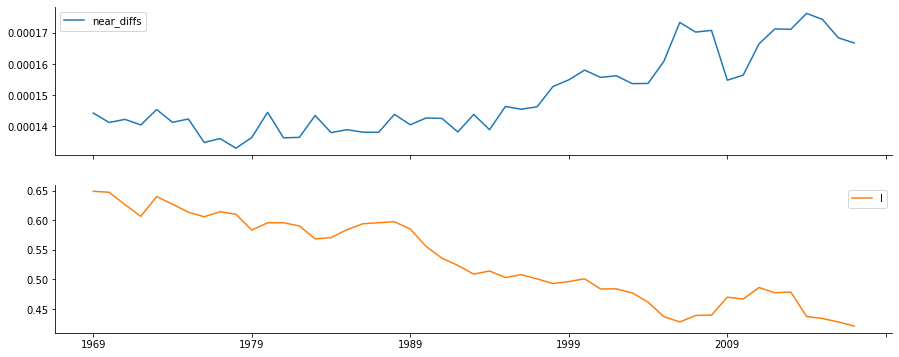

In [104]:
inequalities["near_diffs"] = spatial_gini_results.near_diffs

inequalities[["near_diffs", "I"]].plot.line(
    subplots=True, figsize=(15, 6)
);

sns.despine()